In [1]:
import azureml.core
from azureml.core import Workspace

# Load the workspace from the saved config file
ws = Workspace.from_config()
print('Ready to use Azure ML {} to work with {}'.format(azureml.core.VERSION, ws.name))

Ready to use Azure ML 1.16.0 to work with agogemls


Starting experiment: Titanic-experiment-1
Analyzing 891 rows of data


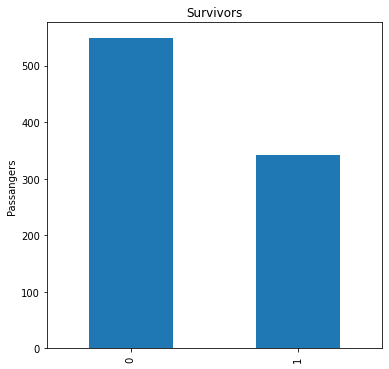

In [2]:
from azureml.core import Experiment
import pandas
import matplotlib.pyplot as plt
%matplotlib inline 

# Create an Azure ML experiment in your workspace
experiment = Experiment(workspace = ws, name = "Titanic-experiment-1")

run = experiment.start_logging()
print("Starting experiment:", experiment.name)

from azureml.core import Dataset
dataset_name = 'Titanic'

# Get a dataset by name
titanic_ds = Dataset.get_by_name(workspace=ws, name=dataset_name)

# Load a TabularDataset into pandas DataFrame
train_df = titanic_ds.to_pandas_dataframe()

# Count the rows and log the result
row_count = (len(train_df))
run.log('observations', row_count)
print('Analyzing {} rows of data'.format(row_count))

# Log summary statistics for numeric columns
columns = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch']
summary_stats = train_df[columns].describe().to_dict()
for col in summary_stats:
    keys = list(summary_stats[col].keys())
    values = list(summary_stats[col].values())
    for index in range(len(keys)):
        run.log_row(col, stat = keys[index], value = values[index])

# Plot and log the count of survived vs non-survived passangers
survived_counts = train_df['Survived'].value_counts()
fig = plt.figure(figsize=(6,6))
ax = fig.gca()    
survived_counts.plot.bar(ax = ax) 
ax.set_title('Survivors') 
ax.set_ylabel('Passangers')
plt.show()
run.log_image(name = 'label distribution', plot = fig)

# Save a sample of the data and upload it to the experiment output
train_df.sample(10).to_csv('sample.csv', index=False, header=True)
run.upload_file(name = 'outputs/sample.csv', path_or_stream = './sample.csv')

In [3]:
import numpy as np
#Data cleansing & Feature engineering
train_df = train_df.drop(['Ticket', 'Cabin', 'PassengerId'], axis=1)

train_df['Title'] = train_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Other')
train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss')
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
train_df['Title'] = train_df['Title'].map(title_mapping)
train_df['Title'] = train_df['Title'].fillna(0).astype(int)
train_df = train_df.drop(['Name'], axis=1)

train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
train_df['IsAlone'] = 0
train_df.loc[train_df['FamilySize'] == 1, 'IsAlone'] = 1
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)

train_df['Sex'] = train_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

freq_port = train_df.Embarked.dropna().mode()[0]
train_df['Embarked'] = train_df['Embarked'].fillna(freq_port)
train_df['Embarked'] = train_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

guess_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        guess_df = train_df[(train_df['Sex'] == i) & (train_df['Pclass'] == j + 1)]['Age'].dropna()
        age_guess = guess_df.median()
        # Convert random age float to nearest .5 age
        guess_ages[i, j] = int(age_guess / 0.5 + 0.5) * 0.5

for i in range(0, 2):
    for j in range(0, 3):
            train_df.loc[(train_df.Age.isnull()) & (train_df.Sex == i) & (train_df.Pclass == j + 1),
                         'Age'] = guess_ages[i, j]

train_df['Age'] = train_df['Age'].astype(int)

train_df.loc[ train_df['Fare'] <= 7.91, 'Fare'] = 0
train_df.loc[(train_df['Fare'] > 7.91) & (train_df['Fare'] <= 14.454), 'Fare'] = 1
train_df.loc[(train_df['Fare'] > 14.454) & (train_df['Fare'] <= 31), 'Fare']   = 2
train_df.loc[ train_df['Fare'] > 31, 'Fare'] = 3
train_df['Fare'] = train_df['Fare'].astype(int)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import joblib

# Separate features and labels
X = train_df.drop("Survived", axis=1)
y = train_df["Survived"]

# Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Set regularization hyperparameter
reg = 0.05
print('Training a logistic regression model with regularization rate of', reg)
run.log('Regularization Rate',  np.float(reg))
model = LogisticRegression(C=1/reg, solver="liblinear").fit(X_train, y_train)

# calculate accuracy
y_hat = model.predict(X_test)
acc = np.average(y_hat == y_test)
print('Accuracy:', acc)
run.log('Accuracy', np.float(acc))

# calculate AUC
y_scores = model.predict_proba(X_test)
auc = roc_auc_score(y_test,y_scores[:,1])
print('AUC: ' + str(auc))
run.log('AUC', np.float(auc))

# Save the trained model in the outputs folder
os.makedirs('outputs', exist_ok=True)
joblib.dump(value=model, filename='outputs/titanic_model.pkl')

# Complete the run
run.complete()

Training a logistic regression model with regularization rate of 0.05
Accuracy: 0.7798507462686567
AUC: 0.823345924908425


In [5]:
# Get logged metrics
metrics = run.get_metrics()
for key in metrics.keys():
        print(key, metrics.get(key))
print('\n')
for file in run.get_file_names():
    print(file)

observations 891
Survived {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [891.0, 0.3838383838383838, 0.4865924542648585, 0.0, 0.0, 0.0, 1.0, 1.0]}
Pclass {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [891.0, 2.308641975308642, 0.8360712409770513, 1.0, 2.0, 3.0, 3.0, 3.0]}
Age {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [714.0, 29.69911764705882, 14.526497332334044, 0.42, 20.125, 28.0, 38.0, 80.0]}
SibSp {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [891.0, 0.5230078563411896, 1.1027434322934275, 0.0, 0.0, 0.0, 1.0, 8.0]}
Parch {'stat': ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'], 'value': [891.0, 0.38159371492704824, 0.8060572211299559, 0.0, 0.0, 0.0, 0.0, 6.0]}
label distribution aml://artifactId/ExperimentRun/dcid.0760d5b5-f3e2-4375-b9ad-14b541fda1c8/label distribution_1603270200.png
Regularization Rate 0.05
Accuracy 0.7798507462686567
A

In [6]:
from azureml.core import Model

# Register the model
run.register_model(model_path='outputs/titanic_model.pkl', model_name='Titanic',
                   tags={'Training context':'Local'},
                   properties={'AUC': run.get_metrics()['AUC'], 'Accuracy': run.get_metrics()['Accuracy']})

Model(workspace=Workspace.create(name='agogemls', subscription_id='da21a094-26a3-472f-991b-e2b11979af40', resource_group='agoge'), name=Titanic, id=Titanic:1, version=1, tags={'Training context': 'Local'}, properties={'AUC': '0.823345924908425', 'Accuracy': '0.7798507462686567'})